<a href="https://colab.research.google.com/github/IgorEisenlohr/MVP-sprint-2/blob/main/MVP_sprint_2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Aluno **Igor Miranda Eisenlohr**
* Problema escolhido foi referente a uma aplicação de **Visão computacional** com DeepLearning.
* O framework escolhido para desenvolver o projeto foi o **TensorFlow**.
* A base de dados contempla imagens de raio-x de pacientes que apresentavam **Pneumonia** e pacientes **normais** sem a doença
* Os dados foram retirados do **Kaggle** e armazenados no **github**.
* https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Na ultima sessão do notebook realizo a avaliação dos modelos sem a necessidade de treinamento, apenas carregando modelos salvos no repositorio

# Trazendo os dados do github por meio de um clone do repositório

In [ ]:
!git clone https://github.com/IgorEisenlohr/MVP-sprint-2.git

Cloning into 'MVP-sprint-2'...
remote: Enumerating objects: 5942, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 5942 (delta 38), reused 90 (delta 33), pack-reused 5843
Receiving objects: 100% (5942/5942), 1.39 GiB | 46.35 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Updating files: 100% (5864/5864), done.


# Importando as bibliotecas necessárias para o desenvolvimento

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import pickle

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
from keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import metrics
from keras.utils import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, SeparableConv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization

tf.random.set_seed(0)
np.random.seed(0)

# Separando os dados de treino, teste e validação

In [ ]:
main_dir = '/content/MVP-sprint-2/chest_xray'

# train
train_dir = os.path.join(main_dir, 'train')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA')
train_normal = os.path.join(train_dir, 'NORMAL')

# val
val_dir = os.path.join(main_dir, 'val')
val_pneumonia = os.path.join(val_dir, 'PNEUMONIA')
val_normal = os.path.join(val_dir, 'NORMAL')

# test
test_dir = os.path.join(main_dir, 'test')
test_pneumonia = os.path.join(test_dir, 'PNEUMONIA')
test_normal = os.path.join(test_dir, 'NORMAL')

## Verificando a contagem de imagens em cada subset

### Treino

In [ ]:
train_pneumonia_files = os.listdir(train_pneumonia)
print(f'Número de imagens de treino para pneumonia: {len(train_pneumonia_files)}')
train_normal_files = os.listdir(train_normal)
print(f'Número de imagens de treino para casos normais: {len(train_normal_files)}')

Número de imagens de treino para pneumonia: 3875
Número de imagens de treino para casos normais: 1341


percebe-se um desbalanceamento das classes de treino

### Validação

In [ ]:
val_pneumonia_files = os.listdir(val_pneumonia)
print(f'Número de imagens de validação para pneumonia: {len(val_pneumonia_files)}')
val_normal_files = os.listdir(val_normal)
print(f'Número de imagens de validação para casos normais: {len(val_normal_files)}')

Número de imagens de validação para pneumonia: 8
Número de imagens de validação para casos normais: 8


percebe-se que a validação contempla pouquissimas imagens, talvez prefira utilizar parte da base de treino para a validação

### Teste

In [ ]:
test_pneumonia_files = os.listdir(test_pneumonia)
print(f'Número de imagens de teste para pneumonia: {len(test_pneumonia_files)}')
test_normal_files = os.listdir(test_normal)
print(f'Número de imagens de teste para casos normais: {len(test_normal_files)}')

Número de imagens de teste para pneumonia: 390
Número de imagens de teste para casos normais: 234


Quantidade ok de imagens para testar a rede

## Visualizando algumas imagens de treino

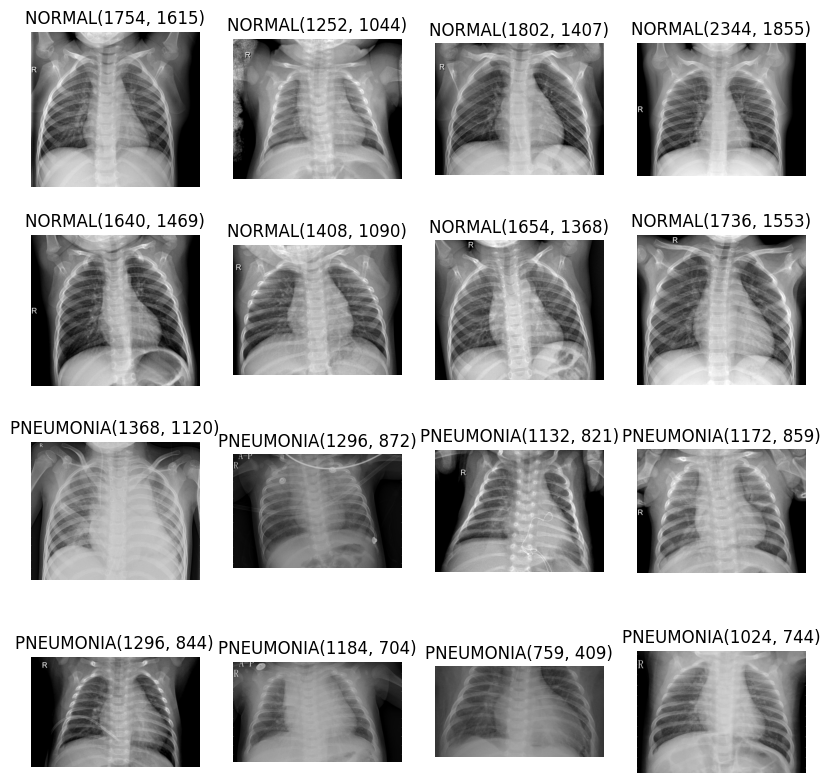

In [ ]:
normal_images = [os.path.join(train_normal, filename) for filename in train_normal_files[0:8]]
pneumonia_images = [os.path.join(train_pneumonia, filename) for filename in train_pneumonia_files[0:8]]
images = normal_images+pneumonia_images

plt.figure(figsize=(10,10))
for i, image in enumerate(images, start=1):
  plt.subplot(4,4,i)
  img = Image.open(image)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(f"{image.split('/')[-2]}{img.size}")

# Preparando os dados que serão utilizados

In [ ]:
shape = 150 # definindo tamanho que será utilizado

# Definindo etapa de Data Augmentation com algumas transformações
# Separando dados de treino em 2 subsets.

train_generator = ImageDataGenerator(rescale= 1./255, # Escala
                                     shear_range = 0.2, # Angulo
                                     zoom_range=0.1, # Zoom
                                     rotation_range=20, # Rotação
                                     brightness_range=[0.5,1.5], # Brilho
                                     horizontal_flip=True, # Inversão horizontal
                                     validation_split=0.2) # % de dados para validação


train_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape), # Tamanho
                                                 batch_size=25, # Batch
                                                 class_mode='binary', # Pneumonia ou não (binário)
                                                 color_mode='grayscale', # Imagens em tons de cinza
                                                 subset='training') # Subset de treino

val_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape), # Tamanho
                                                 batch_size=25, # Batch
                                                 class_mode='binary', # Pneumonia ou não (binário)
                                                 color_mode='grayscale', # Imagens em tons de cinza
                                                 subset='validation') # Subset de validação

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


# Criação da rede

In [ ]:
# Rede Neural

model = Sequential()

# Primeiras camadas para Visão computacional
# Camada 1
model.add(Conv2D(32, (3,3), activation='relu' ,input_shape=(shape,shape,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Camada 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Camada 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Vetor
model.add(Flatten())

# Camada para classificar os dados
model.add(Dense(128,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Em casos clinicos normalmente a acurácia não é a mais adequada. Com isso, vamos nos atentar a outras metricas também
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])

# Visualização de um batch pós transformações

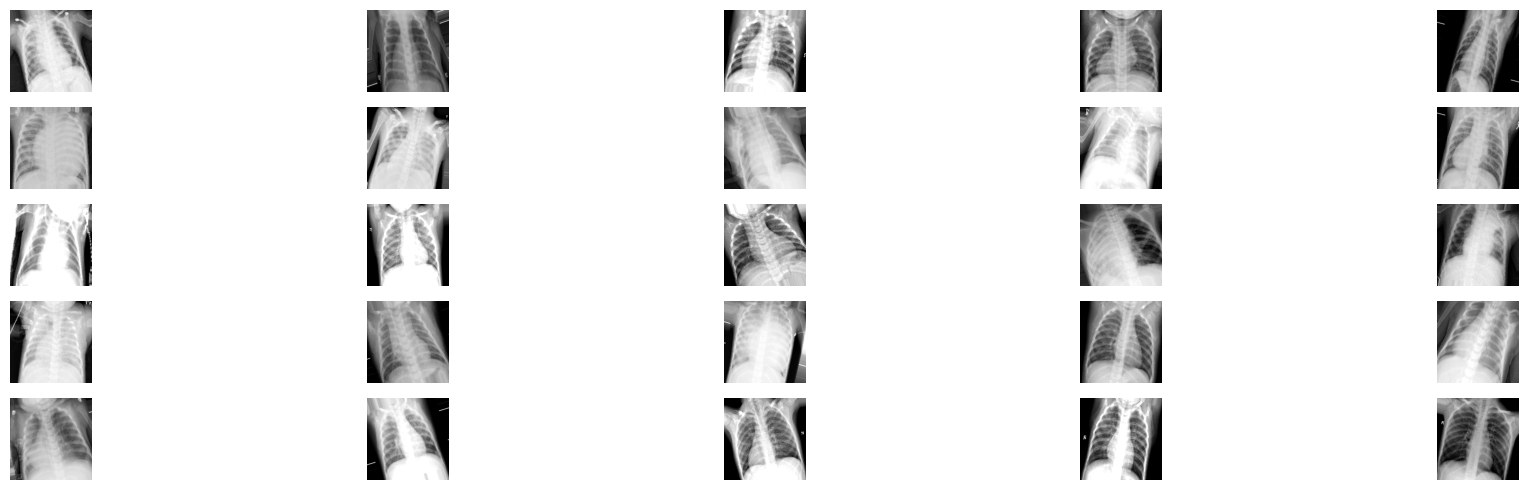

In [ ]:
# Visualizando um batch de imagens após transformações

image_batch = train_data[0][0]

plt.figure(figsize=(20,5))
for i in range(len(image_batch)):
  plt.subplot(5,5,i+1)
  img = array_to_img(image_batch[i])
  plt.imshow(img, cmap='gray')
  plt.axis('off')
plt.tight_layout()

# Definindo callbacks

In [ ]:
# Checkpoint do melhor modelo para os dados de validação
checkpoint = ModelCheckpoint('melhor_modelo.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Alterando o learning_rate caso não tenha melhora do modelo
lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.1)

# Parando a rede caso não tenha mais evolução
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

In [ ]:
# treinando a rede
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=50,
                    validation_data=val_data,
                    callbacks=[checkpoint,lr,early_stopping],
                    validation_steps=len(val_data))

Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 0.9966 - accuracy: 0.8136 - precision: 0.8736 - recall: 0.8758
Epoch 1: val_accuracy improved from -inf to 0.74305, saving model to melhor_modelo.h5
167/167 [==============================] - 73s 365ms/step - loss: 0.9966 - accuracy: 0.8136 - precision: 0.8736 - recall: 0.8758 - val_loss: 9.0450 - val_accuracy: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8950 - precision: 0.9269 - recall: 0.9323
Epoch 2: val_accuracy did not improve from 0.74305
167/167 [==============================] - 60s 361ms/step - loss: 0.2916 - accuracy: 0.8950 - precision: 0.9269 - recall: 0.9323 - val_loss: 4.0952 - val_accuracy: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.9085 - precision: 0.9361 - recall: 0.9410
Epoch 

# Visualizando a evolução das métricas no decorrer das epocas

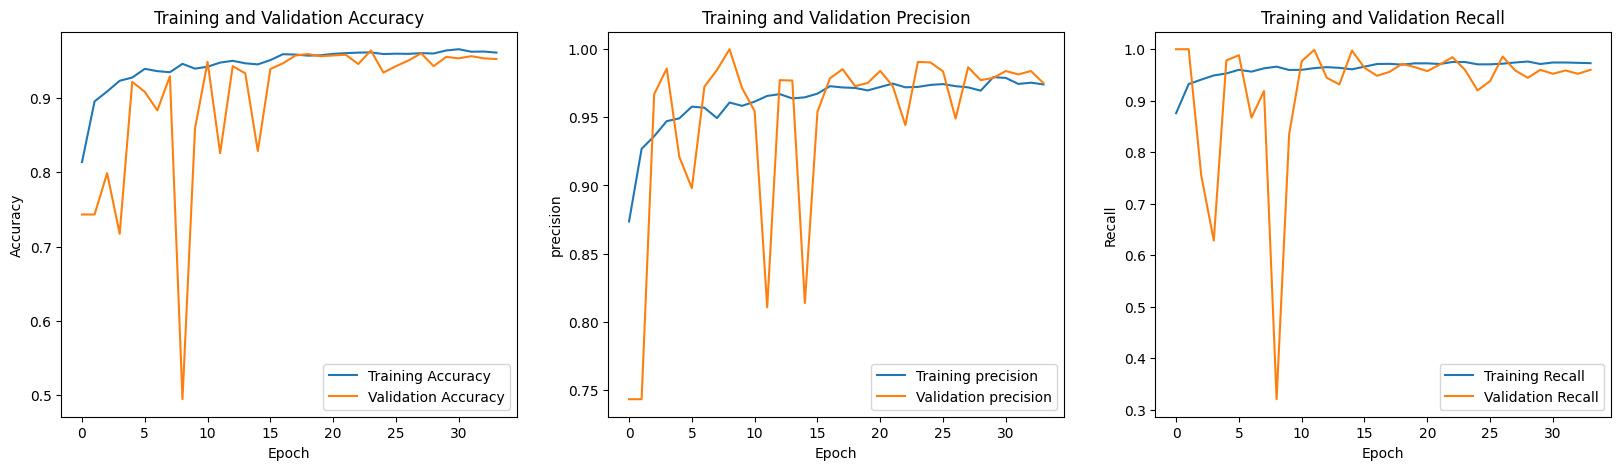

In [ ]:
plt.figure(figsize=(20,5))

# plot da curva de accuracy
plt.subplot(131)
plt.title('Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot da curva de precision
plt.subplot(132)
plt.title('Training and Validation Precision')
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

# plot da curva de recall
plt.subplot(133)
plt.title('Training and Validation Recall')
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()


plt.show()

Com o decorrer das epocas, a partir da 20a, o modelo parece estabilizar os resultados e parece apresentar uma boa métrica tanto para os dados de treino quanto os dados de validação (20% dos dados de treino).

Dessa forma, não parece ter ocorrido um overfitting dos dados, visto que, o algoritmo foi capaz de detectar bem as imagens destinadas para a validação desse modelo

In [ ]:
# Salvando o modelo
model.load_weights('melhor_modelo.h5')

# Avaliando o modelo para os dados de teste

Found 624 images belonging to 2 classes.
624/624 [==============================] - 5s 8ms/step
ROC AUC score: 85.81%
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       234
           1       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.87       624
weighted avg       0.90      0.89      0.88       624



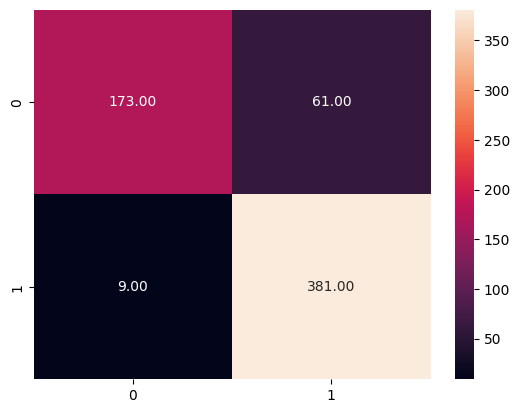

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./255) # Rescale do teste

test_data = test_generator.flow_from_directory(test_dir, # diretorio de teste
                                               target_size=(shape,shape), # shape das imagens
                                               batch_size=1, #batch size
                                               class_mode='binary', # Pneumonia ou não
                                               color_mode='grayscale', # tons de cinza
                                               shuffle=False) # Sem embaralhar

model.evaluate(test_data)
y_pred = model.predict(test_data)
y_pred[y_pred<=0.5] = 0 # Threshold de 0.5 para distinção de classes
y_pred[y_pred>0.5] = 1
cm = confusion_matrix(test_data.classes, y_pred, labels=[0,1]) # Matriz de confusão
sns.heatmap(cm, annot=True, fmt='.2f')

print(f"ROC AUC score: {round(roc_auc_score(test_data.classes, y_pred),4)*100}%") # Roc auc
print(classification_report(test_data.classes, y_pred))

Percebe-se que o algoritmo teve bom poder de classificação. Classificando corretamente quase todos os casos de PNEUMONIA e apresentando um pouco mais de dificuldade ao classificar os casos normais

Por considerar que nesse caso, talvez seja menos prejudicial ao paciente alertar uma possível PNEUMONIA mesmo que não apresente, do que deixar passar um caso da doença afirmando que o paciente está normal, considero que o modelo conseguiu realizar uma boa distinção de classes, principalmente para o pior tipo de erro.

# Utilizando as 16 imagens da pasta de validação (que não foram utilizadas como validação), para simular o modelo em "produção"

In [ ]:
true_labels = test_generator.flow_from_directory(val_dir,
                                               target_size=(shape,shape),
                                               batch_size=1,
                                               class_mode='binary',
                                               color_mode='grayscale',
                                               shuffle=False)

model.evaluate(true_labels)

pred_labels = model.predict(true_labels)
pred_labels[pred_labels<=0.5] = 0
pred_labels[pred_labels>0.5] = 1

Found 16 images belonging to 2 classes.
16/16 [==============================] - 0s 9ms/step


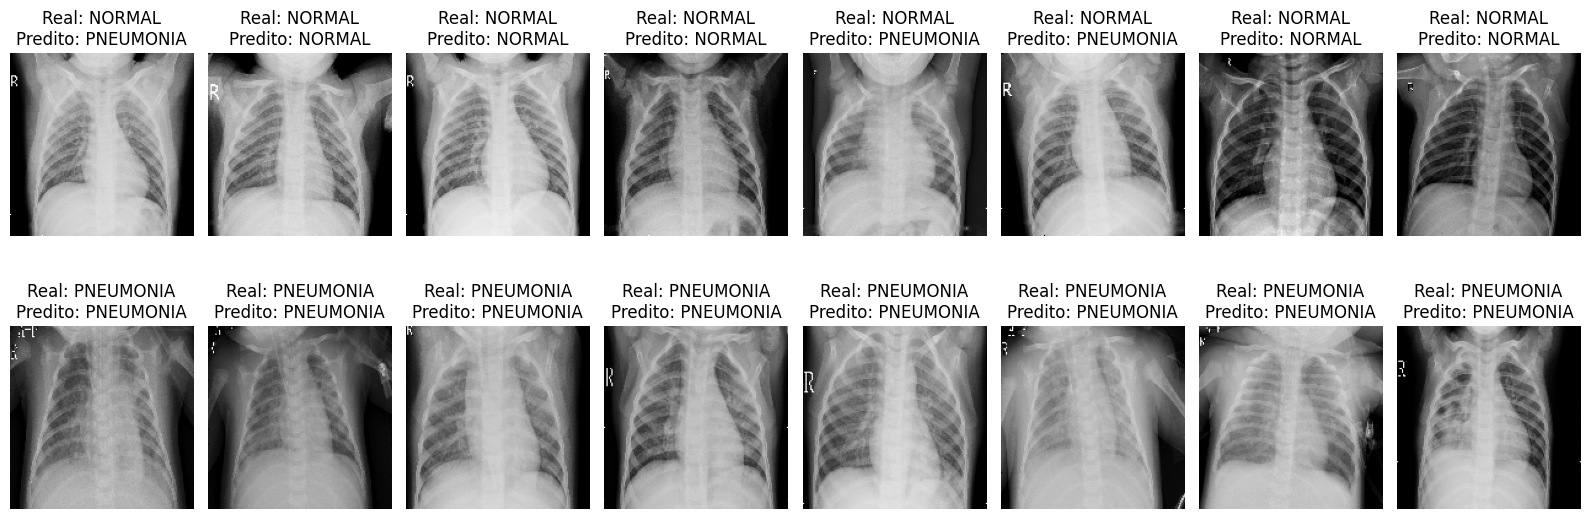

In [ ]:
# Obter as previsões para as imagens de teste
predictions = pred_labels

# Obter as classes reais das imagens de teste
true_classes = true_labels.classes

# Obter os rótulos das classes (por exemplo, 'PNEUMONIA' e 'NORMAL')
class_labels = list(true_labels.class_indices.keys())

# Plotar as imagens com os rótulos
fig, axs = plt.subplots(2, 8, figsize=(16, 6))
axs = axs.ravel()

for i in range(len(true_classes)):
    # Carregar a imagem do diretorio val
    image = array_to_img(true_labels[i][0][0])

    # Obter o valor real da classe e o valor predito
    true_class = class_labels[true_classes[i]]
    predicted_class = class_labels[int(predictions[i] > 0.5)]

    # Plotar a imagem
    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Real: {true_class}\nPredito: {predicted_class}')

plt.tight_layout()
plt.show()

Percebeu-se que para casos de PNEUMONIA o modelo classificou corretamente todas as imagens, e teve maior dificuldade para classificar as imagens normais, porém conseguiu distinguir 6 de 8 imagens normais

## Utilizando um outro modelo mais robusto (ResNet50)

Transformações similares do primeiro modelo

In [ ]:
train_generator = ImageDataGenerator(rescale= 1./255,
                                     shear_range = 0.2,
                                     zoom_range=0.2,
                                     rotation_range=20,
                                     brightness_range=[0.5,1.0],
                                     horizontal_flip=True,
                                     validation_split=0.2)


train_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape),
                                                 batch_size=25,
                                                 class_mode='binary',
                                                 subset='training')

val_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape),
                                                 batch_size=25,
                                                 class_mode='binary',
                                                 subset='validation')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


O modelo ResNet50 não aceita passar imagens em tons de cinza, então foram passadas com as 3 dimensões

In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(shape, shape, 3))
base_model.trainable = False

resnet = Sequential()
resnet.add(base_model)
resnet.add(Flatten())
resnet.add(Dense(1, activation='sigmoid'))
resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
resnet.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 23,616,001
Trainable params: 51,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# definindo um checkpoint similar, porém salvando o arquivo com outro nome
checkpoint_resnet = ModelCheckpoint('melhor_resnet.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Treinando o modelo

In [ ]:
# treinando o modelo com os mesmos parâmetros
resnet_history = resnet.fit(train_data,
                            steps_per_epoch=len(train_data),
                            epochs=50,
                            validation_data=val_data,
                            callbacks=[checkpoint_resnet,lr,early_stopping],
                            validation_steps=len(val_data))

Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.9015 - precision_1: 0.9338 - recall_1: 0.9335
Epoch 1: val_accuracy improved from -inf to 0.95590, saving model to melhor_resnet.h5
167/167 [==============================] - 90s 513ms/step - loss: 0.6911 - accuracy: 0.9015 - precision_1: 0.9338 - recall_1: 0.9335 - val_loss: 0.2314 - val_accuracy: 0.9559 - val_precision_1: 0.9765 - val_recall_1: 0.9639 - lr: 0.0010
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.9317 - precision_1: 0.9542 - recall_1: 0.9539
Epoch 2: val_accuracy did not improve from 0.95590
167/167 [==============================] - 80s 481ms/step - loss: 0.4237 - accuracy: 0.9317 - precision_1: 0.9542 - recall_1: 0.9539 - val_loss: 0.5933 - val_accuracy: 0.9271 - val_precision_1: 0.9861 - val_recall_1: 0.9148 - lr: 0.0010
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.9454 - precision_1: 0.96

In [ ]:
# salvando o modelo
resnet.load_weights('melhor_resnet.h5')

# Visualizando a evolução das métricas no decorrer das epocas

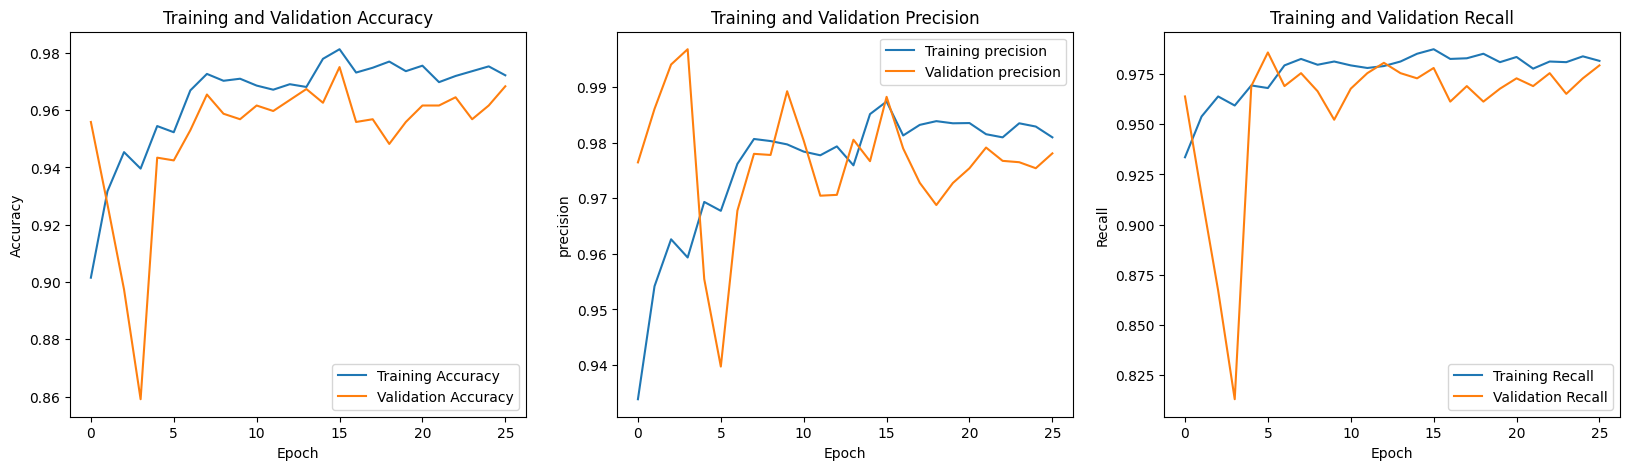

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title('Training and Validation Accuracy')
plt.plot(resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(132)
plt.title('Training and Validation Precision')
plt.plot(resnet_history.history['precision_1'], label='Training precision')
plt.plot(resnet_history.history['val_precision_1'], label='Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

plt.subplot(133)
plt.title('Training and Validation Recall')
plt.plot(resnet_history.history['recall_1'], label='Training Recall')
plt.plot(resnet_history.history['val_recall_1'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()


plt.show()

Percebeu-se maior oscilação durante as epocas, e que o modelo executou um Early Stopping anterior ao modelo 1. Precisando de menos épocas para alcançar seu melhor desempenho (de acordo com as condições impostas ao modelo)

# Avaliando o ResNet50

Found 624 images belonging to 2 classes.
624/624 [==============================] - 7s 11ms/step
ROC AUC score: 86.79%
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       234
           1       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



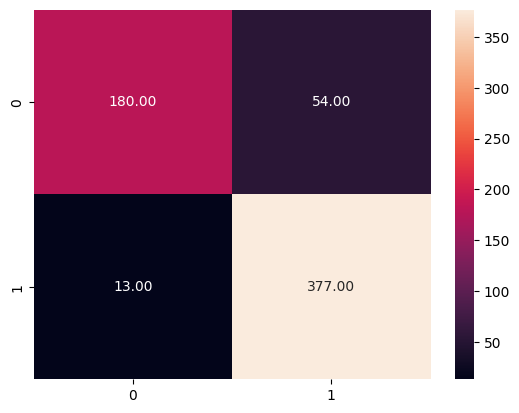

In [ ]:
test_data = test_generator.flow_from_directory(test_dir,
                                               target_size=(shape,shape),
                                               batch_size=1,
                                               class_mode='binary',
                                               shuffle=False)

resnet.evaluate(test_data)
y_pred = resnet.predict(test_data)
y_pred[y_pred<=0.5] = 0 # Mesmo threshold definido
y_pred[y_pred>0.5] = 1
cm = confusion_matrix(test_data.classes, y_pred, labels=[0,1]) # Matriz de confusão
sns.heatmap(cm, annot=True, fmt='.2f')

print(f"ROC AUC score: {round(roc_auc_score(test_data.classes, y_pred),4)*100}%")
print(classification_report(test_data.classes, y_pred))

Percebe-se que o modelo apresentou um melhor valor de ROC AUC e foi mais capaz de realizar a distinção entre as duas classes. Apresentou um aumento no erro de distinção entre os casos de pneumonia, porém uma melhora para distinguir os casos normais.

Caberia uma análise técnica com profissionais especializados no ramo da saúde para avaliar esse tradeoff de classificação entre as classes

# Utilizando as 16 imagens da pasta de validação (que não foram utilizadas como validação), para simular o modelo em "produção"

In [ ]:
true_labels = test_generator.flow_from_directory(val_dir,
                                               target_size=(shape,shape),
                                               batch_size=1,
                                               class_mode='binary',
                                               shuffle=False)

resnet.evaluate(true_labels)

pred_labels = resnet.predict(true_labels)
pred_labels[pred_labels<=0.5] = 0
pred_labels[pred_labels>0.5] = 1

Found 16 images belonging to 2 classes.
16/16 [==============================] - 0s 11ms/step


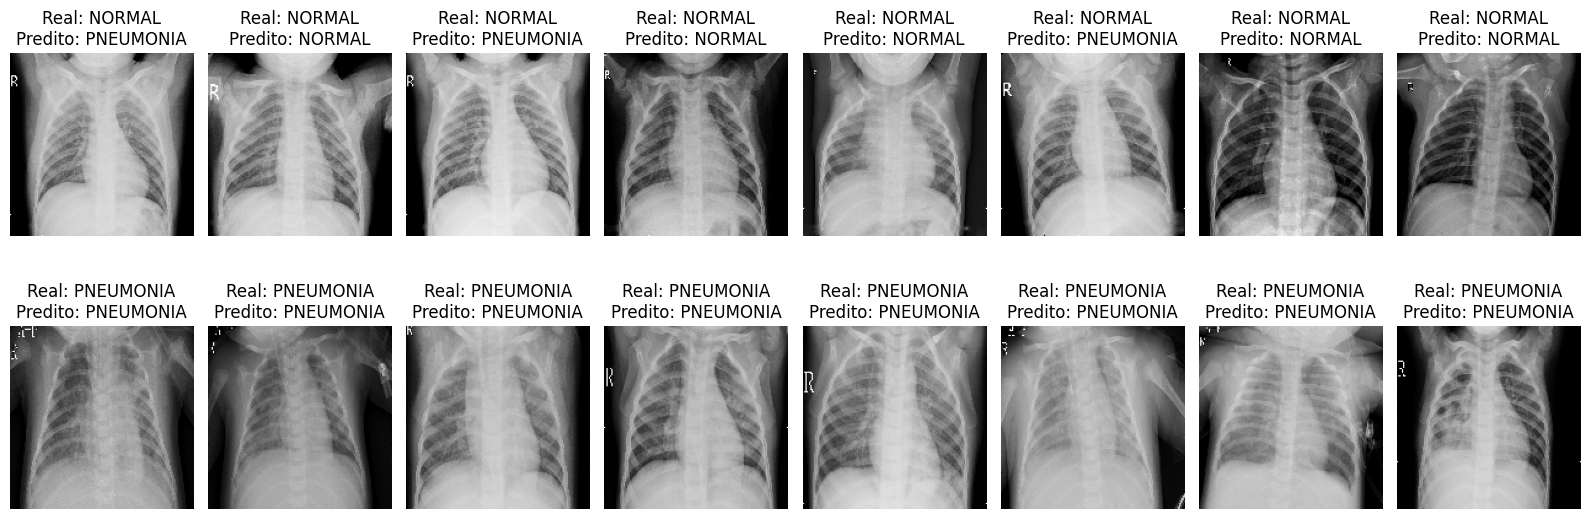

In [ ]:
# Obter as previsões para as imagens de teste
predictions = pred_labels

# Obter as classes reais das imagens de teste
true_classes = true_labels.classes

# Obter os rótulos das classes (por exemplo, 'PNEUMONIA' e 'NORMAL')
class_labels = list(true_labels.class_indices.keys())

# Plotar as imagens com os rótulos
fig, axs = plt.subplots(2, 8, figsize=(16, 6))
axs = axs.ravel()

for i in range(len(true_classes)):
    # Carregar a imagem do diretorio val
    image = array_to_img(true_labels[i][0][0])

    # Obter o valor real da classe e o valor predito
    true_class = class_labels[true_classes[i]]
    predicted_class = class_labels[int(predictions[i] > 0.5)]

    # Plotar a imagem
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Real: {true_class}\nPredito: {predicted_class}')

plt.tight_layout()
plt.show()

Com o modelo realizando a predição dessas 16 imagens, me pareceu que o modelo estaria mais tendencioso a predizer PNEUMONIA e acabou errando mais casos Normais que o primeiro modelo. Porém na etapa de teste, utilizando um numero mais significante de imagens, o resultado foi o oposto e a ResNet50 teria sido mais eficaz

# Modelo 3: adicionando peso para balanceamento do modelo 1

Percebe-se que as imagens de maior brilho tendem a ser classificadas como PNEUMONIA, vou tentar aumentar o brilho para dificultar essa clara distinção

In [ ]:
shape = 150 # definindo tamanho que será utilizado

# Definindo etapa de Data Augmentation com algumas transformações
# Separando dados de treino em 2 subsets.

train_generator = ImageDataGenerator(rescale= 1./255,
                                     shear_range = 0.2,
                                     zoom_range=0.1,
                                     rotation_range=20,
                                     brightness_range=[0.5,1.5],
                                     horizontal_flip=True,
                                     validation_split=0.2)


train_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape), # Tamanho
                                                 batch_size=25, # Batch
                                                 class_mode='binary', # Pneumonia ou não (binário)
                                                 color_mode='grayscale', # Imagens em tons de cinza
                                                 subset='training') # Subset de treino

val_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape), # Tamanho
                                                 batch_size=25, # Batch
                                                 class_mode='binary', # Pneumonia ou não (binário)
                                                 color_mode='grayscale', # Imagens em tons de cinza
                                                 subset='validation') # Subset de validação

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


Como as classes são desbalanceadas, vou tentar utilizar pesos para as classes

In [ ]:
train_pneumonia_count = len(train_pneumonia_files)
train_normal_count = len(train_normal_files)
total_train = train_pneumonia_count + train_normal_count

In [ ]:
initial_bias = np.log([train_pneumonia_count/train_normal_count])
initial_bias

array([1.06113006])

In [ ]:
weight_for_0 = (1 / train_normal_count)*(total_train)/2.0
weight_for_1 = (1 / train_pneumonia_count)*(total_train)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Peso classe 0: {weight_for_0}')
print(f'Peso classe 1: {weight_for_1}')

Peso classe 0: 1.9448173005219984
Peso classe 1: 0.6730322580645162


In [ ]:
# Rede Neural

model_b = Sequential()

# Primeiras camadas para Visão computacional
# Camada 1
model_b.add(Conv2D(32, (3,3), activation='relu' ,input_shape=(shape,shape,1)))
model_b.add(BatchNormalization())
model_b.add(MaxPooling2D(pool_size=(2,2)))
model_b.add(Dropout(0.5))

# Camada 2
model_b.add(Conv2D(64, (3,3), activation='relu'))
model_b.add(BatchNormalization())
model_b.add(MaxPooling2D(pool_size=(2,2)))
model_b.add(Dropout(0.5))

# Camada 3
model_b.add(Conv2D(128, (3,3), activation='relu'))
model_b.add(BatchNormalization())
model_b.add(MaxPooling2D(pool_size=(2,2)))
model_b.add(Dropout(0.5))


# Vetor
model_b.add(Flatten())

# Camada para classificar os dados
model_b.add(Dense(128,activation='relu'))
model_b.add(Dense(1, activation='sigmoid'))

# Em casos clinicos normalmente a acurácia não é a mais adequada. Com isso, vamos nos atentar a outras metricas também
model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name='precision_2'), metrics.Recall(name='recall_2')])

In [ ]:
# Checkpoint do melhor modelo para os dados de validação
checkpoint_b = ModelCheckpoint('melhor_modelo_2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Alterando o learning_rate caso não tenha melhora do modelo
lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.1)

# Parando a rede caso não tenha mais evolução
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

In [ ]:
# treinando o modelo com os mesmos parâmetros
model_b_history = model_b.fit(train_data,
                            steps_per_epoch=len(train_data),
                            epochs=50,
                            validation_data=val_data,
                            callbacks=[checkpoint_b,lr,early_stopping],
                            class_weight=class_weight,
                            validation_steps=len(val_data))

Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 0.9761 - accuracy: 0.7321 - precision_2: 0.8578 - recall_2: 0.7665
Epoch 1: val_accuracy improved from -inf to 0.74305, saving model to melhor_modelo_2.h5
167/167 [==============================] - 64s 362ms/step - loss: 0.9761 - accuracy: 0.7321 - precision_2: 0.8578 - recall_2: 0.7665 - val_loss: 17.8280 - val_accuracy: 0.7430 - val_precision_2: 0.7430 - val_recall_2: 1.0000 - lr: 0.0010
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.8577 - precision_2: 0.9600 - recall_2: 0.8435
Epoch 2: val_accuracy did not improve from 0.74305
167/167 [==============================] - 61s 364ms/step - loss: 0.2977 - accuracy: 0.8577 - precision_2: 0.9600 - recall_2: 0.8435 - val_loss: 7.8302 - val_accuracy: 0.7430 - val_precision_2: 0.7430 - val_recall_2: 1.0000 - lr: 0.0010
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.8922 - precision_2: 0

In [ ]:
# Salvando o modelo
model_b.load_weights('melhor_modelo_2.h5')

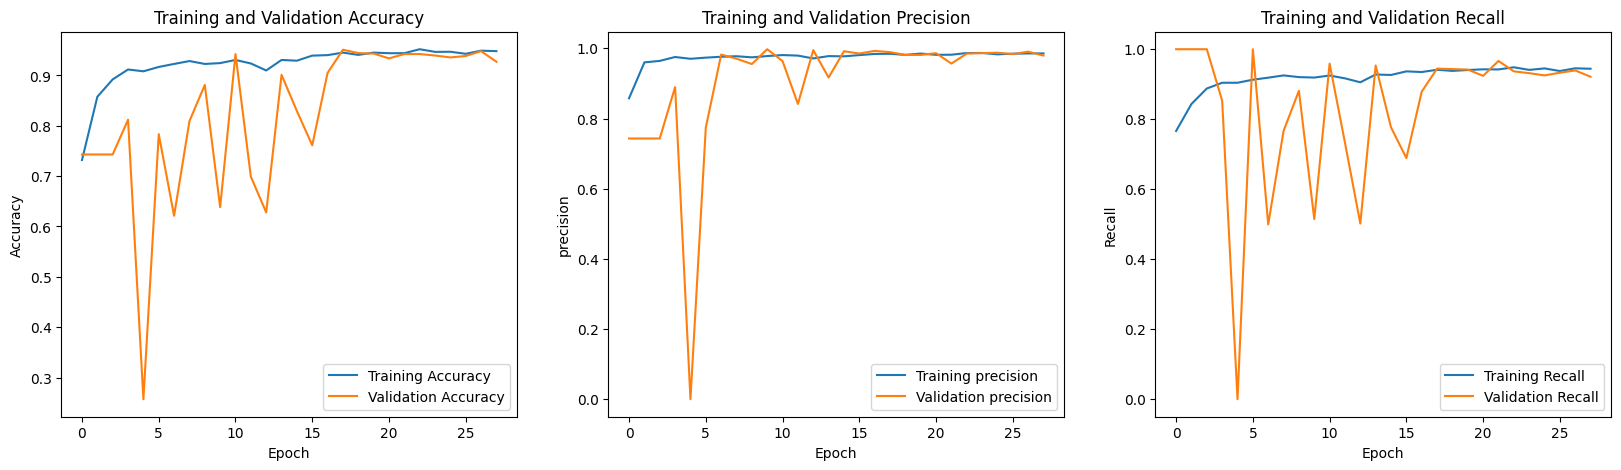

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title('Training and Validation Accuracy')
plt.plot(model_b_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_b_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(132)
plt.title('Training and Validation Precision')
plt.plot(model_b_history.history['precision_2'], label='Training precision')
plt.plot(model_b_history.history['val_precision_2'], label='Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

plt.subplot(133)
plt.title('Training and Validation Recall')
plt.plot(model_b_history.history['recall_2'], label='Training Recall')
plt.plot(model_b_history.history['val_recall_2'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()


plt.show()

Assim como no primeiro modelo, o modelo com o balanceamento das classes parece se estabilizar a partir da 15-20 épocas e as métricas de teste parecem estar de acordo com o de treinamento. Dessa forma, não parece ter ocorrido overfitting ou underfitting dos dados

Found 624 images belonging to 2 classes.
624/624 [==============================] - 6s 9ms/step
ROC AUC score: 87.78%
              precision    recall  f1-score   support

           0       0.92      0.80      0.85       234
           1       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



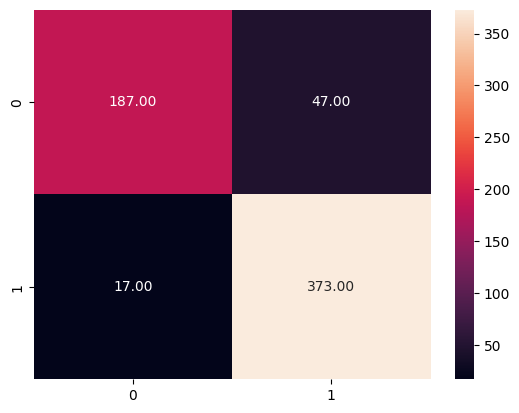

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./255) # Rescale do teste

test_data = test_generator.flow_from_directory(test_dir, # diretorio de teste
                                               target_size=(shape,shape), # shape das imagens
                                               batch_size=1, #batch size
                                               class_mode='binary', # Pneumonia ou não
                                               color_mode='grayscale', # tons de cinza
                                               shuffle=False) # Sem embaralhar

model_b.evaluate(test_data)
y_pred = model_b.predict(test_data)
y_pred[y_pred<=0.5] = 0 # Threshold de 0.5 para distinção de classes
y_pred[y_pred>0.5] = 1
cm = confusion_matrix(test_data.classes, y_pred, labels=[0,1]) # Matriz de confusão
sns.heatmap(cm, annot=True, fmt='.2f')

print(f"ROC AUC score: {round(roc_auc_score(test_data.classes, y_pred),4)*100}%") # Roc auc
print(classification_report(test_data.classes, y_pred))

Percebe-se que, assim como no modelo 2 (ResNet50), o modelo com o balanceamento dos dados obteve ainda mais esse tradeoff entre as classes, visto que a classificação de normais melhorou, porém a classificação de pneumonia reduziu um pouco. Porém, no geral, a métrica de ROC AUC foi levemente superior

In [ ]:
true_labels = test_generator.flow_from_directory(val_dir,
                                               target_size=(shape,shape),
                                               batch_size=1,
                                               class_mode='binary',
                                               color_mode='grayscale',
                                               shuffle=False)

model_b.evaluate(true_labels)

pred_labels = model_b.predict(true_labels)
pred_labels[pred_labels<=0.5] = 0
pred_labels[pred_labels>0.5] = 1

Found 16 images belonging to 2 classes.
16/16 [==============================] - 0s 10ms/step


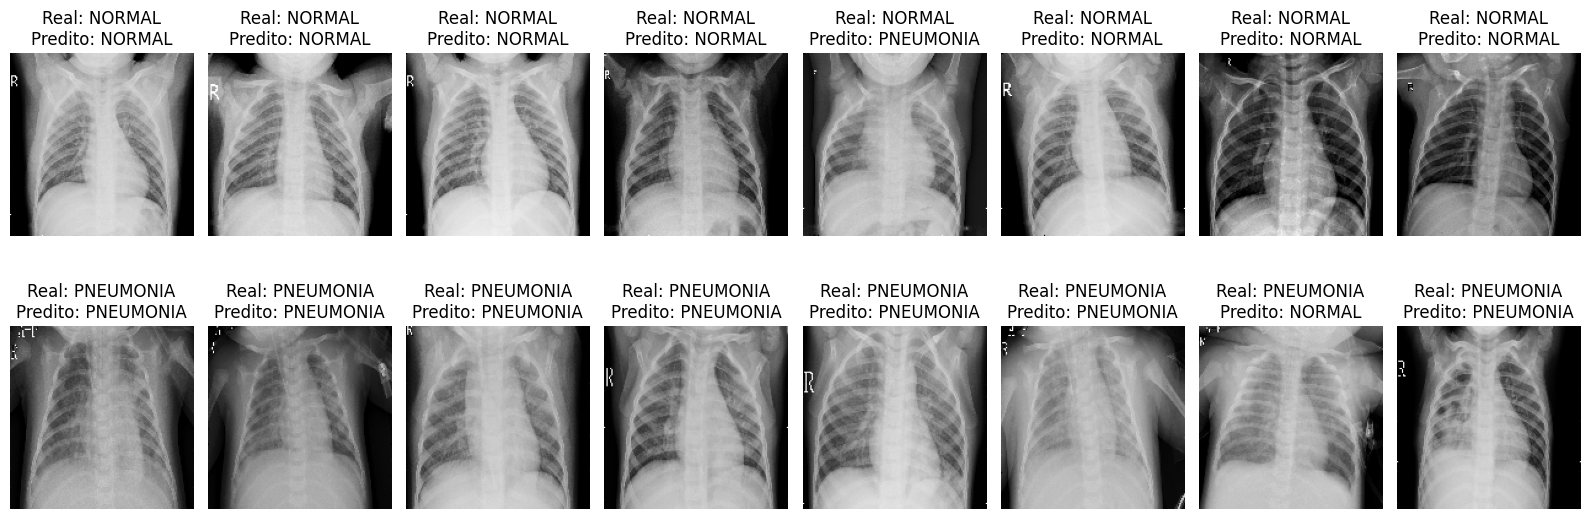

In [ ]:
# Obter as previsões para as imagens de teste
predictions = pred_labels

# Obter as classes reais das imagens de teste
true_classes = true_labels.classes

# Obter os rótulos das classes (por exemplo, 'PNEUMONIA' e 'NORMAL')
class_labels = list(true_labels.class_indices.keys())

# Plotar as imagens com os rótulos
fig, axs = plt.subplots(2, 8, figsize=(16, 6))
axs = axs.ravel()

for i in range(len(true_classes)):
    # Carregar a imagem do diretorio val
    image = array_to_img(true_labels[i][0][0])

    # Obter o valor real da classe e o valor predito
    true_class = class_labels[true_classes[i]]
    predicted_class = class_labels[int(predictions[i] > 0.5)]

    # Plotar a imagem
    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Real: {true_class}\nPredito: {predicted_class}')

plt.tight_layout()
plt.show()

Esse modelo, provavelmente pelo fato de ter pesos balanceados de acordo com as classes, conseguiu realizar predições mais balanceadas e acertar a maioria de ambos os casos em "produção" errando apenas 1 das 8 imagens de cada classe. Parecendo ser menos tendencioso aos casos de pneumonia

# Carregando modelos treinados para avaliação sem precisar retreinar

## Modelo 1

Found 624 images belonging to 2 classes.
624/624 [==============================] - 6s 10ms/step
ROC AUC score: 85.04%
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       234
           1       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



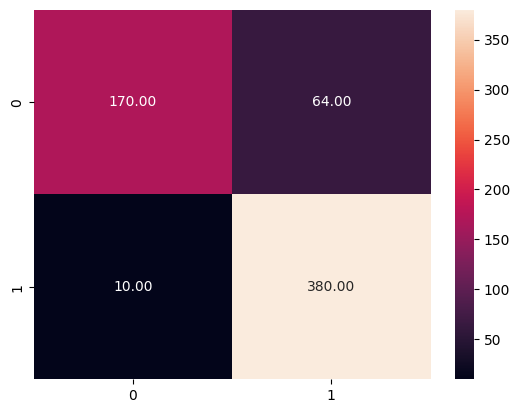

In [ ]:
import tensorflow as tf
modelo1 = tf.keras.models.load_model('/content/MVP-sprint-2/modelos/melhor_modelo.h5')

test_generator = ImageDataGenerator(rescale = 1./255) # Rescale do teste

test_data = test_generator.flow_from_directory(test_dir, # diretorio de teste
                                               target_size=(150,150), # shape das imagens
                                               batch_size=1, #batch size
                                               class_mode='binary', # Pneumonia ou não
                                               color_mode='grayscale', # tons de cinza
                                               shuffle=False) # Sem embaralhar

modelo1.evaluate(test_data)
y_pred = modelo1.predict(test_data)
y_pred[y_pred<=0.5] = 0 # Threshold de 0.5 para distinção de classes
y_pred[y_pred>0.5] = 1
cm = confusion_matrix(test_data.classes, y_pred, labels=[0,1]) # Matriz de confusão
sns.heatmap(cm, annot=True, fmt='.2f')

print(f"ROC AUC score: {round(roc_auc_score(test_data.classes, y_pred),4)*100}%") # Roc auc
print(classification_report(test_data.classes, y_pred))

## ResNet50

Found 624 images belonging to 2 classes.
624/624 [==============================] - 8s 11ms/step
ROC AUC score: 86.79%
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       234
           1       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



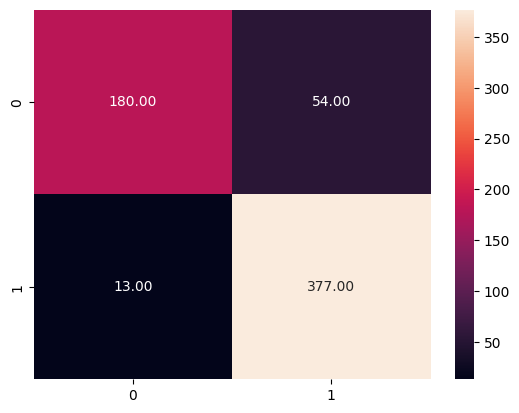

In [ ]:
resnet = tf.keras.models.load_model('/content/MVP-sprint-2/modelos/melhor_resnet .h5')

test_generator = ImageDataGenerator(rescale = 1./255) # Rescale do teste

test_data = test_generator.flow_from_directory(test_dir,
                                               target_size=(150,150),
                                               batch_size=1,
                                               class_mode='binary',
                                               shuffle=False)

resnet.evaluate(test_data)
y_pred = resnet.predict(test_data)
y_pred[y_pred<=0.5] = 0 # Threshold de 0.5 para distinção de classes
y_pred[y_pred>0.5] = 1
cm = confusion_matrix(test_data.classes, y_pred, labels=[0,1]) # Matriz de confusão
sns.heatmap(cm, annot=True, fmt='.2f')

print(f"ROC AUC score: {round(roc_auc_score(test_data.classes, y_pred),4)*100}%") # Roc auc
print(classification_report(test_data.classes, y_pred))

## Ultimo modelo

Found 624 images belonging to 2 classes.
624/624 [==============================] - 5s 8ms/step
ROC AUC score: 87.78%
              precision    recall  f1-score   support

           0       0.92      0.80      0.85       234
           1       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



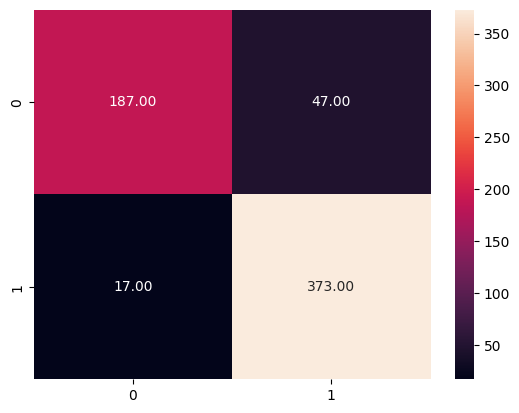

In [ ]:
import tensorflow as tf
modelo2 = tf.keras.models.load_model('/content/MVP-sprint-2/modelos/melhor_modelo_2.h5')

test_generator = ImageDataGenerator(rescale = 1./255) # Rescale do teste

test_data = test_generator.flow_from_directory(test_dir, # diretorio de teste
                                               target_size=(150,150), # shape das imagens
                                               batch_size=1, #batch size
                                               class_mode='binary', # Pneumonia ou não
                                               color_mode='grayscale', # tons de cinza
                                               shuffle=False) # Sem embaralhar

modelo2.evaluate(test_data)
y_pred = modelo2.predict(test_data)
y_pred[y_pred<=0.5] = 0 # Threshold de 0.5 para distinção de classes
y_pred[y_pred>0.5] = 1
cm = confusion_matrix(test_data.classes, y_pred, labels=[0,1]) # Matriz de confusão
sns.heatmap(cm, annot=True, fmt='.2f')

print(f"ROC AUC score: {round(roc_auc_score(test_data.classes, y_pred),4)*100}%") # Roc auc
print(classification_report(test_data.classes, y_pred))